## CHALLENGE: model evaluation

We got the houseprice data with set of variables. There are two tasks:
1) To create a regression model for prediction SALEPRICE of the house based on the best performance measurements. We will try to use different types of regression models and do cross validation. 
2) Include variable from external source and validate it

Let's take a look at the data:

In [181]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import seaborn as sns
import warnings
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [182]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

### We will start from analysing valiables and target values

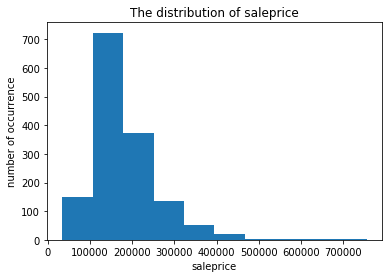

In [183]:
#Let's review the saleprice distribution
plt.hist(house_df.saleprice)
plt.title("The distribution of saleprice")
plt.xlabel("saleprice")
plt.ylabel("number of occurrence")
plt.show()

In [184]:
#here our variables with their types
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

#### Let's split our variable into two groups: categorical and numerical

In [185]:
non_numeric_columns = house_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


In [186]:
numeric_columns = house_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


We will check numerical variables on having missing values 

In [187]:
total_missing = house_df.isnull().sum().sort_values(ascending=False)
percent_missing = (house_df.isnull().sum()/house_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head (25)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


So we see that some of the data is missing on purpose. If the field is empty means that either this feauture is false either it wasn't filled by a listing agent. For the purpose of modelling we will check first what variables are most correlated with the target and will decide shoud we change the missing values if any 

In [188]:
np.abs(house_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

Let's clean the variables which correlate more than 0.5 with saleprice :

- overallqual      0.790982
- grlivarea        0.708624
- garagecars       0.640409
- garagearea       0.623431
- totalbsmtsf      0.613581
- firstflrsf       0.605852
- fullbath         0.560664
- totrmsabvgrd     0.533723
- yearbuilt        0.522897
- yearremodadd     0.507101

Let's check outliers among these variables with boxplot method:

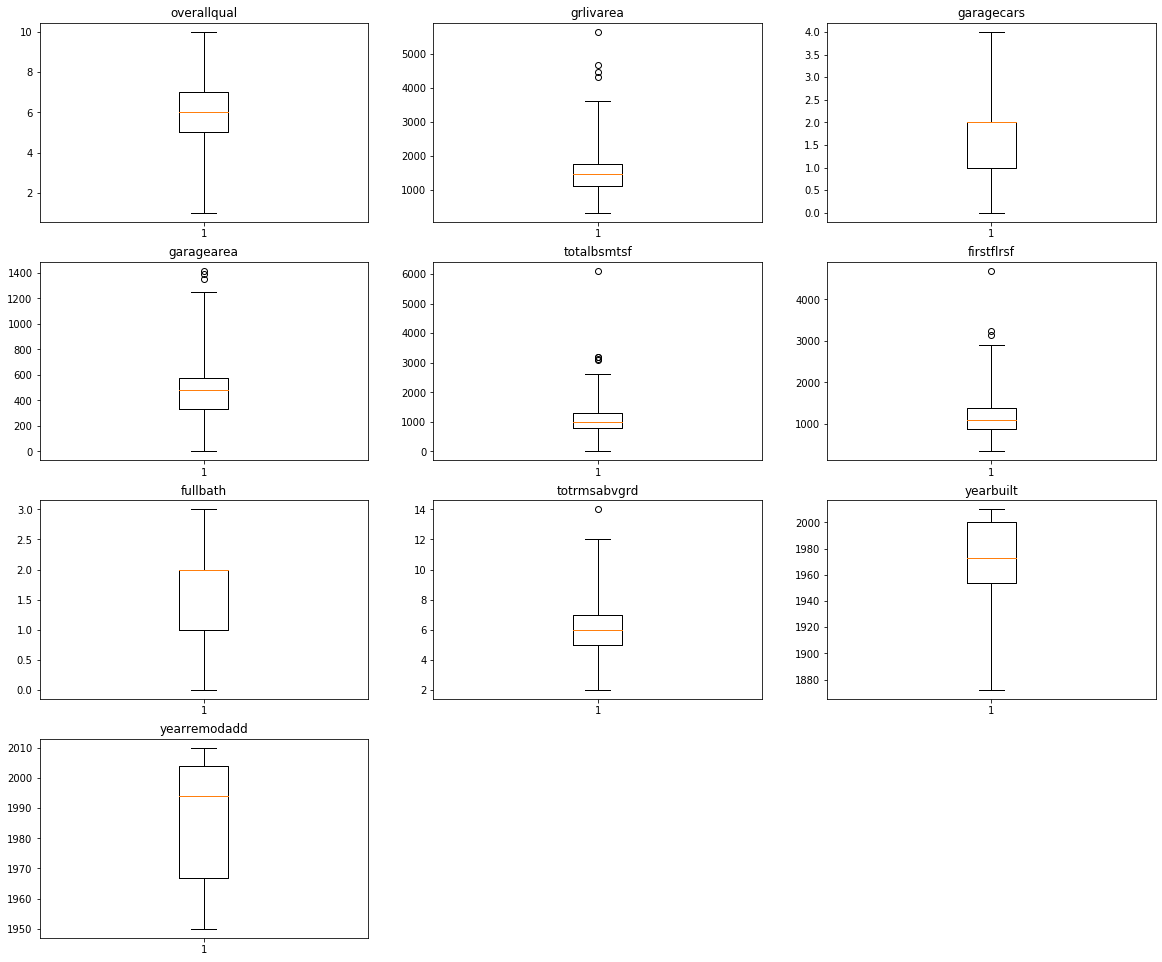

In [189]:
plt.figure(figsize=(20,30))
col_dict = {'overallqual':1, 'grlivarea':2, 'garagecars':3, 'garagearea':4,'totalbsmtsf':5, 'firstflrsf':6, 
            'fullbath':7, 'totrmsabvgrd':8, 'yearbuilt':9, 'yearremodadd':10,
            }
for variable, i in col_dict.items():
    plt.subplot(7,3,i) 
    plt.boxplot(house_df[variable],whis=3)
    plt.title(variable)

We will limit the values of the outfitters from the top with one-way windsorization technique - we will set the values of the highest end of the distribution to the value of the 95th percentile. 

In [190]:
from scipy.stats.mstats import winsorize

house_df["grlivarea"] = winsorize(house_df["grlivarea"], (0, 0.05))
house_df["garagearea"] = winsorize(house_df["garagearea"], (0, 0.05))
house_df["totalbsmtsf"] = winsorize(house_df["totalbsmtsf"], (0, 0.05))
house_df["firstflrsf"] = winsorize(house_df["firstflrsf"], (0, 0.05))

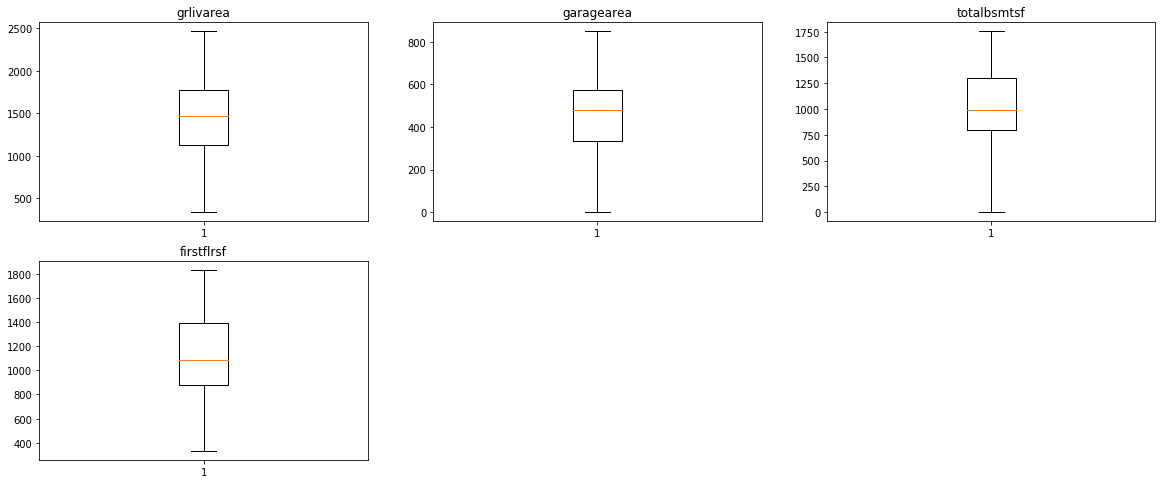

In [192]:
#let's check the winsorized values
plt.figure(figsize=(20,30))
col_dict = {'grlivarea':1,'garagearea':2, 'totalbsmtsf':3, 'firstflrsf':4 }
for variable, i in col_dict.items():
    plt.subplot(7,3,i) 
    plt.boxplot(house_df[variable],whis=20)
    plt.title(variable)

We successfully clean the outliers.

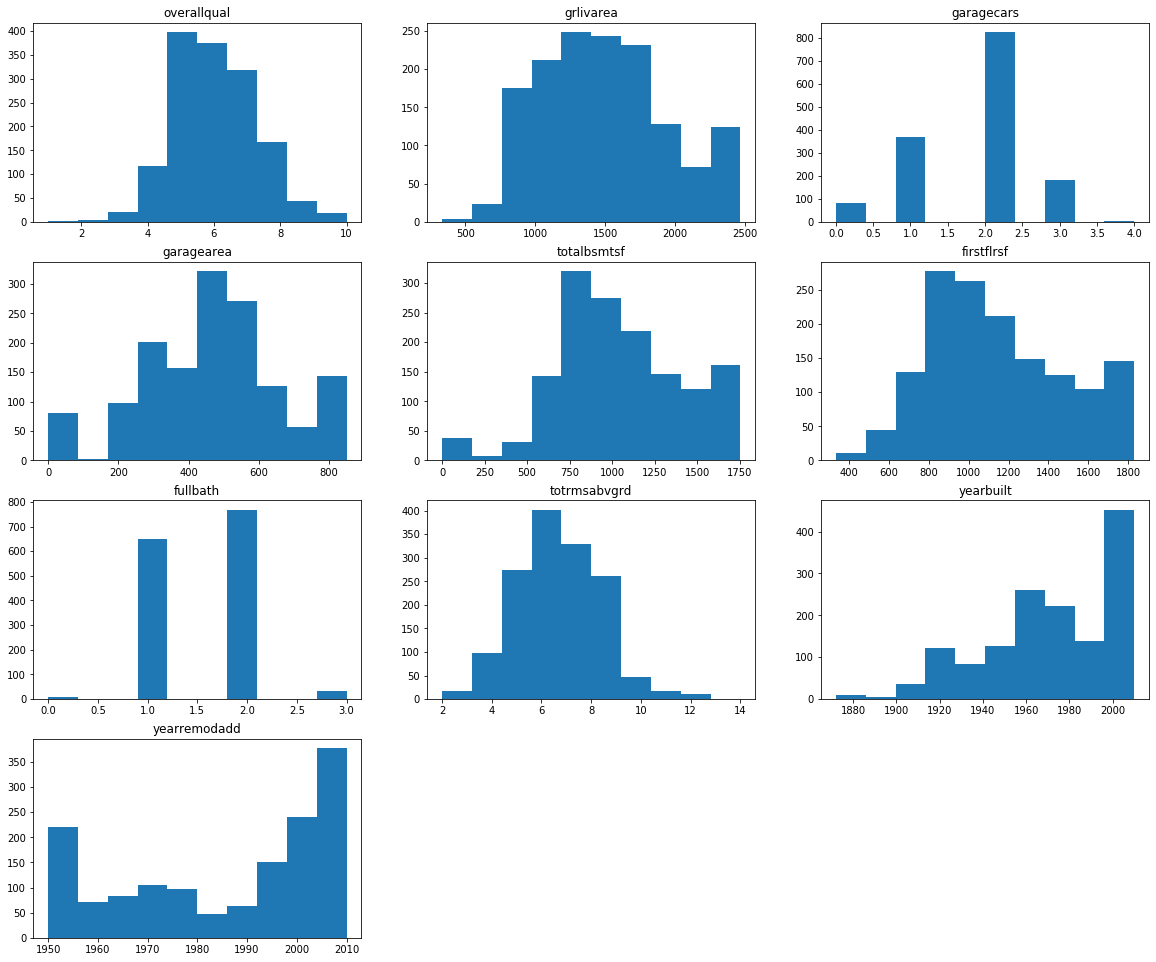

In [193]:
#Now let's procceed with the univariate analysis and find out how the variable distribution looking
#let's check the winsorized values
plt.figure(figsize=(20,30))
col_dict = {'overallqual':1, 'grlivarea':2, 'garagecars':3, 'garagearea':4,'totalbsmtsf':5, 'firstflrsf':6, 
            'fullbath':7, 'totrmsabvgrd':8, 'yearbuilt':9, 'yearremodadd':10}
for variable, i in col_dict.items():
    plt.subplot(7,3,i) 
    plt.hist(house_df[variable])
    plt.title(variable)

In [194]:
#Some variables visually not normally distributed.
#We will use the monotonic transformations approach - log transformation for some of them.
#This will help us apply statistical techniques for future analysis.

house_df["grlivarea"] = np.log(house_df["grlivarea"])
house_df["yearbuilt"] = np.log(house_df["yearbuilt"])
house_df["yearremodadd"] = np.log(house_df["yearremodadd"])

### Let's review categorical variables and choose what will be included into the model

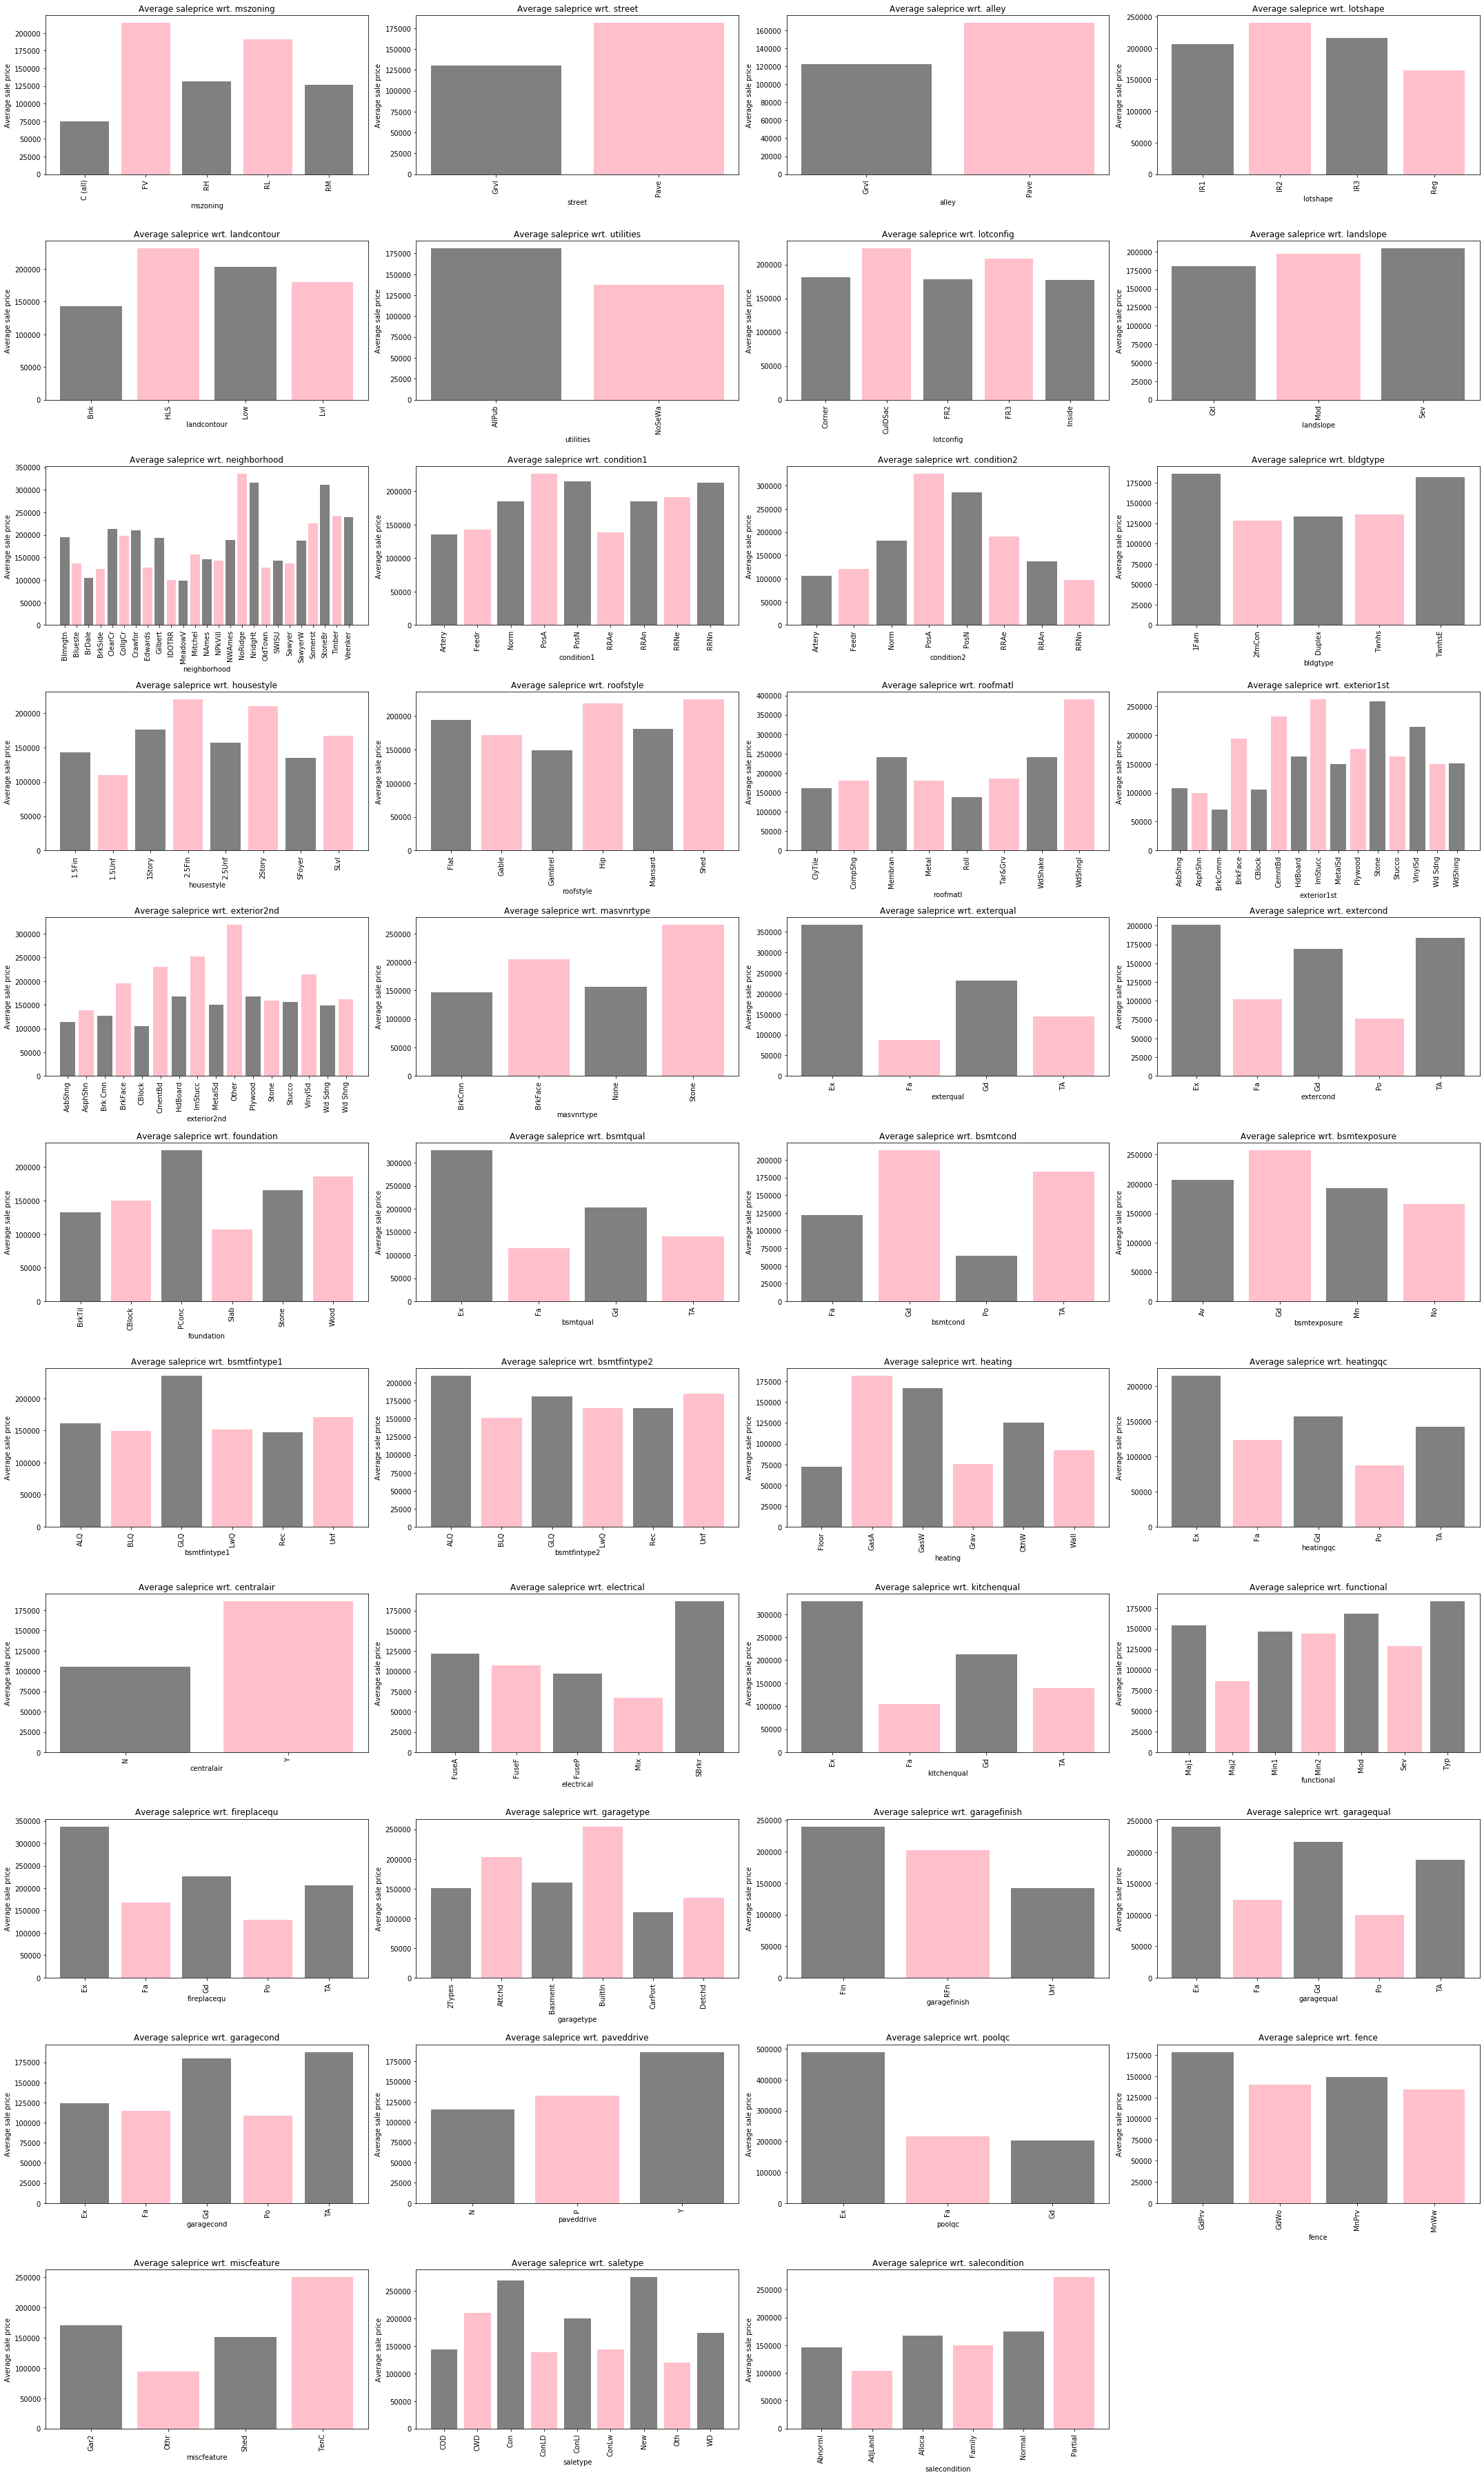

In [195]:
plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(house_df.groupby(column)["saleprice"].mean().index, house_df.groupby(column)["saleprice"].mean(),
           color=("grey","pink"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

It looks like there is significant difference in saleprice for the next categorical variables: 
    - exterqual
    - kitchenqual
    Let's keep verify it in our model

In [196]:
house_df = pd.concat([house_df,pd.get_dummies(house_df.exterqual, prefix="exter", drop_first=True)], axis=1)
house_df = pd.concat([house_df,pd.get_dummies(house_df.kitchenqual, prefix="kitchen", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(house_df.exterqual, prefix="exter", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_df.kitchenqual, prefix="kitchen", drop_first=True).columns)

Let's check the correlation between variables that are most correlated with saleprice and exclude if anything is highly correlated with each other

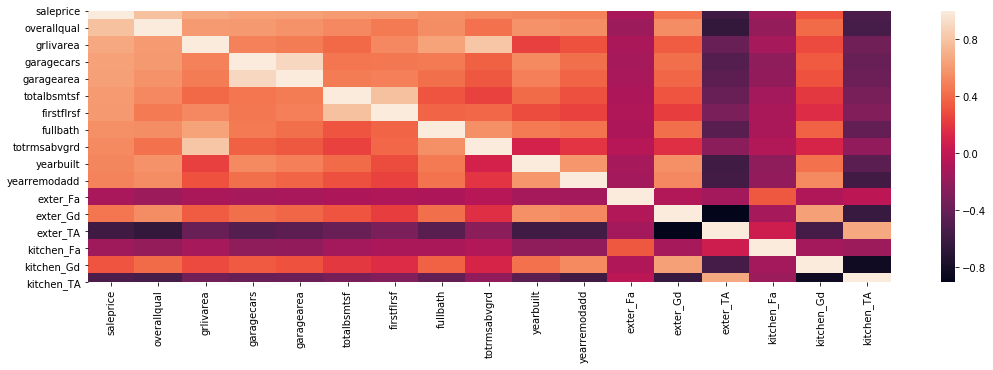

In [197]:
#It will be a good idea to remove all corelated variable that correlate with each other.
house1_df = house_df[['saleprice', 'overallqual',
              'grlivarea', 'garagecars', 'garagearea', 
              'totalbsmtsf', 'firstflrsf', 'fullbath',
              'totrmsabvgrd', 'yearbuilt', 'yearremodadd']+dummy_column_names]
plt.figure(figsize=(18,5))

sns.heatmap(house1_df.corr())
plt.show()

we see some high correlation between overallqual - exter_TA, yearremoddadd - exter_TA
Let's first check P values and then decide should we keep these variables or exclude.

## MODELS:

## Let's start with OLS model

In [198]:
# Y is the target variable
Y = house_df['saleprice']
# X is the feature set which includes
X = house_df[['overallqual',
              'grlivarea', 'garagecars', 'garagearea', 
              'totalbsmtsf', 'firstflrsf', 'fullbath',
              'totrmsabvgrd', 'yearbuilt', 'yearremodadd']+dummy_column_names]

import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     337.6
Date:                Tue, 04 Feb 2020   Prob (F-statistic):               0.00
Time:                        07:01:42   Log-Likelihood:                -17408.
No. Observations:                1460   AIC:                         3.485e+04
Df Residuals:                    1443   BIC:                         3.494e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -5.434e+06    1.1e+06     -4.951      0.000   -7.59e+06   -3.28e+06
overallqual   1.554e+04   1275.446     12.182      0.000     1.3e+04     1.8e+04
grlivarea     4.666e+04   6568.319      7.104      0.000    3.38e+04    5.95e+04
garagecars    4909.0828   3077.171      1.595      0.111   -1127.125    1.09e+04
garagearea      33.9278     11.024      3.078      0.002      12.303      55.553
totalbsmtsf     25.3585      4.496      5.640      0.000      16.539      34.178
firstflrsf      16.2106      5.096      3.181      0.001       6.214      26.208
fullbath      -233.3680   2606.298     -0.090      0.929   -5345.906    4879.170
totrmsabvgrd  3787.7235   1071.012      3.537      0.000    1686.815    5888.632
yearbuilt      3.44e+05   9.64e+04      3.567      0.000    1.55e+05    5.33e+05
yearremodadd  3.374e+05   1.33e+05      2.528      0.012    7.56e+04    5.99e+05
exter_Fa     -4.194e+04    1.3e+04     -3.226      0.001   -6.74e+04   -1.64e+04
exter_Gd     -4.076e+04   6490.089     -6.280      0.000   -5.35e+04    -2.8e+04
exter_TA     -4.685e+04   7200.985     -6.506      0.000    -6.1e+04   -3.27e+04
kitchen_Fa   -3.899e+04   8590.708     -4.538      0.000   -5.58e+04   -2.21e+04
kitchen_Gd   -3.989e+04   4874.140     -8.184      0.000   -4.95e+04   -3.03e+04
kitchen_TA   -4.695e+04   5529.418     -8.492      0.000   -5.78e+04   -3.61e+04
==============================================================================
Omnibus:                      750.267   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24721.543
Skew:                           1.770   Prob(JB):                         0.00
Kurtosis:                      22.846   Cond. No.                     1.94e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Based on P_value the statistically significant variables are overallqual, grlivarea, garagearea, totalbsmtsf, firstflrsf, yearbuilt, yearremodadd, and all dummies columns. The amount of the variavles mught be too big sdo let's fit the overfitting. Let's exclude unsignificant variables and check the results:

In [200]:
#Now let's exclude statistically insignificant variables from the model and re-estimate it:
Y = house_df['saleprice']
# X is the feature set
X = house_df[['overallqual',
              'grlivarea', 'garagearea', 
              'totalbsmtsf', 'firstflrsf',
              'yearbuilt', 'yearremodadd']+dummy_column_names]
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     410.6
Date:                Tue, 04 Feb 2020   Prob (F-statistic):               0.00
Time:                        07:01:49   Log-Likelihood:                -17416.
No. Observations:                1460   AIC:                         3.486e+04
Df Residuals:                    1446   BIC:                         3.493e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -5.654e+06   1.06e+06     -5.351      0.000   -7.73e+06   -3.58e+06
overallqual   1.545e+04   1275.962     12.112      0.000     1.3e+04     1.8e+04
grlivarea     6.429e+04   4294.417     14.971      0.000    5.59e+04    7.27e+04
garagearea      48.1479      6.436      7.481      0.000      35.524      60.772
totalbsmtsf     23.9748      4.490      5.339      0.000      15.167      32.783
firstflrsf      16.3195      5.112      3.193      0.001       6.292      26.347
yearbuilt     3.436e+05    9.2e+04      3.734      0.000    1.63e+05    5.24e+05
yearremodadd   3.54e+05   1.34e+05      2.651      0.008     9.2e+04    6.16e+05
exter_Fa     -4.263e+04   1.31e+04     -3.265      0.001   -6.82e+04    -1.7e+04
exter_Gd     -4.342e+04   6474.751     -6.706      0.000   -5.61e+04   -3.07e+04
exter_TA     -4.917e+04   7201.929     -6.827      0.000   -6.33e+04    -3.5e+04
kitchen_Fa   -4.037e+04   8599.761     -4.694      0.000   -5.72e+04   -2.35e+04
kitchen_Gd   -4.125e+04   4858.579     -8.491      0.000   -5.08e+04   -3.17e+04
kitchen_TA   -4.763e+04   5541.360     -8.595      0.000   -5.85e+04   -3.68e+04
==============================================================================
Omnibus:                      786.480   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25991.592
Skew:                           1.898   Prob(JB):                         0.00
Kurtosis:                      23.319   Cond. No.                     1.86e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.86e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The results resemble the previous model's results. The estimated coefficients are close to the previous model and all are statistically significant. Adjusted R square is almost 80% which is pretty significant

Now it's time to mover deeper into evaluation and **quantifying the performance of a model on the training set**

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [160]:
X_train = sm.add_constant(X_train)

In [161]:
#We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     332.6
Date:                Tue, 04 Feb 2020   Prob (F-statistic):               0.00
Time:                        06:42:18   Log-Likelihood:                -13916.
No. Observations:                1168   AIC:                         2.786e+04
Df Residuals:                    1154   BIC:                         2.793e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -5.059e+06   1.17e+06     -4.334   

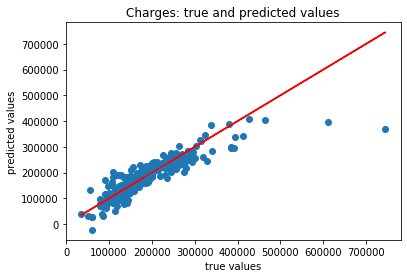

Mean absolute error of the prediction is: 23959.159056395325
Mean squared error of the prediction is: 1519089061.3330793
Root mean squared error of the prediction is: 38975.49308646498
Mean absolute percentage error of the prediction is: 14.527860138922394


In [162]:
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [163]:
# X is the feature set

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)
# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

The number of observations in training set is 1168
The number of observations in test set is 292
R-squared of the model in the training set is: 0.7893483869012454
-----Test set statistics-----
R-squared of the model in the test set is: 0.7737330922779204
Mean absolute error of the prediction is: 23959.159056395987
Mean squared error of the prediction is: 1519089061.3330545
Root mean squared error of the prediction is: 38975.49308646466
Mean absolute percentage error of the prediction is: 14.527860138922719


- R-squared of the model in the training set is: 0.79
- R-squared of the model in the test set is: 0.78 that means we have a strong model for the predictions of the target variable


## RIDGE, LASSO, ELASTIC REGRESSION with CV

Let's choose the best model using cross validation.
For defining alfa we do  k-fold cross-validation

In [69]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [167]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.01
R-squared of the model in training set is: 0.7893280817952374
-----Test set statistics-----
R-squared of the model in test set is: 0.7733936164728092
Mean absolute error of the prediction is: 24008.128920461982
Mean squared error of the prediction is: 1521368201.4305763
Root mean squared error of the prediction is: 39004.72024551101
Mean absolute percentage error of the prediction is: 14.5667666618109


In [166]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-10
R-squared of the model in training set is: 0.7893483869012451
-----Test set statistics-----
R-squared of the model in test set is: 0.7737330922779045
Mean absolute error of the prediction is: 23959.159056397897
Mean squared error of the prediction is: 1519089061.3331614
Root mean squared error of the prediction is: 38975.49308646603
Mean absolute percentage error of the prediction is: 14.527860138924343


In [72]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8031427824136375
-----Test set statistics-----
R-squared of the model in test set is: 0.79063286040774
Mean absolute error of the prediction is: 22814.62988972923
Mean squared error of the prediction is: 1405629019.1044905
Root mean squared error of the prediction is: 37491.71934046891
Mean absolute percentage error of the prediction is: 13.706812313622793


We have all of the models comparable with their differences between R-squared of the model in training set and in the test set so let's choose the model with the lowest Mean absolute percentage error. This will be OLS with the very insignificantly lower value.

# Part 2
Adding external values into the dataset and verifying their influence. 
In the govermental sources we found database for the *Employment rate* and *Investment into US economy* by years. Let's merge these dataframes with our main for house prices and see how this variables affected saleprice 

In [201]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()
house_df ['Year'] = house_df ['yrsold']

In [170]:
#Let's add investment flow data
Investment = pd.read_csv ('monthly_csv_Investm.csv')
Investment['Year'] = Investment['Date'].str[:4]
Investment['Year'] = Investment['Year'].astype(int)
Investment.head()

,Date,Total Equity,Domestic Equity,World Equity,Hybrid,Total Bond,Taxable Bond,Municipal Bond,Total,Year
0,2007-01-31,27364,5723,21641,5321,15287,12453,2834,47972,2007
1,2007-02-28,25306,8411,16895,5164,15064,11926,3137,45533,2007
2,2007-03-31,6551,-486,7037,3764,15782,12925,2857,26097,2007
3,2007-04-30,16063,-163,16225,4384,13701,12346,1355,34148,2007
4,2007-05-31,-2876,-14176,11300,4318,20813,17215,3598,22256,2007


In [171]:
Investment_df = Investment.groupby(["Year"])["Total Bond"].sum().head()

In [172]:
#Let's add unemployment rate and 
Unemployment = pd.read_csv ('aat1_csv.csv')
Unemployment['Year'] = Unemployment['year']
Unemployment['Year'] = Unemployment['Year'].astype(int)

In [173]:
result = pd.merge (Investment_df, Unemployment, on  = 'Year')
result.head(10)

,Year,Total Bond,year,population,labor_force,population_percent,employed_total,employed_percent,agrictulture_ratio,nonagriculture_ratio,unemployed,unemployed_percent,not_in_labor,footnotes
0,2007,110609,2007,231867,153124,66.0,146047,63.0,2095,143952,7078,4.6,78743,1.0
1,2008,30032,2008,233788,154287,66.0,145362,62.2,2168,143194,8924,5.8,79501,1.0
2,2009,371238,2009,235801,154142,65.4,139877,59.3,2103,137775,14265,9.3,81659,1.0
3,2010,232342,2010,237830,153889,64.7,139064,58.5,2206,136858,14825,9.6,83941,1.0


In [175]:
result_df = pd.merge (house_df, result, on  = 'Year')

Into the dataframe house_df let's add *unemployment rate* and *Total bonds*

In [176]:
#Let's add to the model two more variables  - unemployed_percent and total bond
#Now let's exclude statistically insignificant variables from the model and re-estimate it:
Y = result_df['saleprice']
# X is the feature set
X = result_df[['overallqual',
              'grlivarea', 'garagearea', 
              'totalbsmtsf', 'firstflrsf',
              'yearbuilt', 'yearremodadd', 'unemployed_percent', 'Total Bond']]
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     405.1
Date:                Tue, 04 Feb 2020   Prob (F-statistic):               0.00
Time:                        06:51:57   Log-Likelihood:                -13733.
No. Observations:                1146   AIC:                         2.749e+04
Df Residuals:                    1136   BIC:                         2.754e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.313e+06   1.41e+05     -9.339      0.000   -1.59e+06   -1.04e+06
overallqual         1.947e+04   1355.420     14.365      0.000    1.68e+04    2.21e+04
grlivarea             46.2031      3.072     15.040      0.000      40.176      52.230
garagearea            42.3237      7.065      5.990      0.000      28.461      56.186
totalbsmtsf           20.3534      4.766      4.271      0.000      11.002      29.704
firstflrsf            11.7919      5.605      2.104      0.036       0.794      22.790
yearbuilt            278.8767     53.521      5.211      0.000     173.865     383.888
yearremodadd         352.6656     71.196      4.953      0.000     212.975     492.356
unemployed_percent     1.3855    985.474      0.001      0.999   -1932.169    1934.940
Total Bond            -0.0011      0.016     -0.071      0.943      -0.032       0.029
==============================================================================
Omnibus:                      419.312   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58564.212
Skew:                          -0.577   Prob(JB):                         0.00
Kurtosis:                      38.002   Cond. No.                     2.81e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.81e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We see that our two variable have high P-value and there is no reason to include them into our model. (P = 0.99 and P = 0.943)

# Conclusion: 
### For the modeling of the sales price of the houses (saleprice) we will be using OLS model with the most signigicant variables: 
                - overallqual,
              grlivarea, garagearea, 
              totalbsmtsf, firstflrsf,
              yearbuilt, yearremodadd, exterqual, kitchenqual